In [1]:
# to get started, we will import these libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sodapy import Socrata
import shapely
from shapely.geometry import shape

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

# Graphics
import plotly.express as px

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# next we will connect to the data portal to load in vacant parcel data from LA County Assessor
client = Socrata("data.lacounty.gov", None)

# The website says this dataset has 176K rows, we are going to try to call in all of them using 180K in case more have been added. However, we are also going to limit our data to Los Angeles incorporated
results = client.get("vcaw-zeg9", limit=180000, where="taxratearea_city=='LOS ANGELES'")

# We'll need to convert to pandas DataFrame
vacdf = pd.DataFrame.from_records(results)

vacdf.sample(5)

usecodedescchar1 roll_homeownersexemp situsunit recordingdate  \
15283       Industrial                    0                20141229   
4860       Residential                    0                20061208   
33054      Residential                    0                20080421   
13125      Residential                    0                20111223   
27594      Residential                    0                20040315   

      effectiveyearbuilt istaxableparcel roll_totlandimp roll_perspropexemp  \
15283                  0               Y          131457                  0   
4860                   0               Y          558774                  0   
33054                  0               Y           39063                  0   
13125                  0               Y          130636                  0   
27594                  0               Y             587                  0   

                               parcelboundarydescription roll_landbaseyear  \
15283  RESUB OF THE KELLAR TRACT LOT 21 AND E 2 FT OF...              1990   
4860   LAND DESC IN DOC 2729582,061208 POR OF LOTS 2 ...              2007   
33054                         P M 140-8-9 EX OF ST LOT B              1979   
13125  TRACT NO 7433 LOT COM AT MOST N COR OF LOT 5 T...              2012   
27594             PASADENA VILLA TRACT LOT   21 BLK   46              1975   

       ...                                         location_1 bathrooms  \
15283  ...  {'latitude': '34.00236501', 'needs_recoding': ...         0   
4860   ...  {'latitude': '34.23886997', 'needs_recoding': ...         0   
33054  ...  {'latitude': '34.18323197', 'needs_recoding': ...         0   
13125  ...  {'latitude': '34.03174526', 'needs_recoding': ...         0   
27594  ...  {'latitude': '34.09474322', 'needs_recoding': ...         0   

      sqftmain situsdirection roll_realestateexemp   center_lat    situszip  \
15283        0                                   0  34.00236501  90058-1936   
4860         0                                   0  34.23886997               
33054        0                                   0  34.18323197               
13125        0                                   0  34.03174526               
27594        0                                   0  34.09474322               

      yearbuilt                          propertylocation situszip5  
15283         0  4511 STAUNTON AVE  LOS ANGELES CA  90058     90058  
4860          0                                       NaN       NaN  
33054         0                                       NaN       NaN  
13125         0                                       NaN       NaN  
27594         0                                       NaN       NaN  

[5 rows x 51 columns]

In [3]:
# we need to replace null objects with "n/a" in order to analyze and plot this important data on the designated use type of these parcels later
vacdf['usecodedescchar1'].fillna('N/A')

0         Industrial
1        Residential
2        Residential
3        Residential
4        Residential
            ...     
33086    Residential
33087    Residential
33088    Residential
33089     Commercial
33090    Residential
Name: usecodedescchar1, Length: 33091, dtype: object

In [4]:
# we will need to convert our df to gdf. Since data is in lat/lon's we will assign crs to WGS84 (epsg:4326)
vacgdf = gpd.GeoDataFrame(vacdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(vacdf.center_lon, vacdf.center_lat))

In [5]:
# importing our community boundaries dataset by referencing API from data source and using shapely to convert the geometries

comdf = pd.read_json( r'https://data.lacounty.gov/resource/frhs-h972.json' )
comdf = comdf[comdf["lcity"].str.contains("Los Angeles") == True]
comdf['the_geom'] = comdf['the_geom'].apply(shape)
comgdf = gpd.GeoDataFrame(comdf).set_geometry('the_geom')

comgdf.sample(5)

objectid city_type        lcity                             label  \
152       108      City  Los Angeles     Los Angeles - Lincoln Heights   
14        164      City  Los Angeles            Los Angeles - Van Nuys   
117       118      City  Los Angeles             Los Angeles - Melrose   
11         86      City  Los Angeles  Los Angeles - Florence-Firestone   
28        129      City  Los Angeles               Los Angeles - Palms   

      source  shape_starea  shape_stlength  \
152  LA City  9.105672e+07    60756.009942   
14   LA City  2.055831e+08    92099.630215   
117  LA City  1.249168e+08    83828.090506   
11   LA City  7.053592e+07    41435.669231   
28   LA City  5.106984e+07    36741.539345   

                                              the_geom           community  
152  MULTIPOLYGON (((-118.19006 34.09722, -118.1903...     Lincoln Heights  
14   MULTIPOLYGON (((-118.46773 34.22142, -118.4677...            Van Nuys  
117  MULTIPOLYGON (((-118.30918 34.09077, -118.3085...             Melrose  
11   MULTIPOLYGON (((-118.25631 33.98948, -118.2563...  Florence-Firestone  
28   MULTIPOLYGON (((-118.40320 34.02955, -118.4012...               Palms

In [6]:
# setting projection so we can map this

comgdf = comgdf.set_crs('epsg:4326')

In [7]:
# set the mapbox access token
token = 'pk.eyJ1IjoieW9obWFuIiwiYSI6IkxuRThfNFkifQ.u2xRJMiChx914U7mOZMiZw'
px.set_mapbox_access_token(token)

In [8]:
# Do the spatial join
join = gpd.sjoin(vacgdf, comgdf, how='left')
join.head()

usecodedescchar1 roll_homeownersexemp situsunit recordingdate  \
0       Industrial                    0                20140123   
1      Residential                    0                20141112   
2      Residential                    0                20090406   
3      Residential                    0                20111007   
4      Residential                    0                19970805   

  effectiveyearbuilt istaxableparcel roll_totlandimp roll_perspropexemp  \
0                  0               Y           42410                  0   
1                  0               Y           28000                  0   
2                  0               Y               0                  0   
3                  0               Y          114438                  0   
4                  0               Y          391931                  0   

                           parcelboundarydescription roll_landbaseyear  ...  \
0  OWENSMOUTH S 50 FT OF N 100 FT OF W 231.43 FT ...              1975  ...   
1  *LAND DESC IN DOC 0002484, 76-4-26 *TR=22481*P...              2015  ...   
2  TR=53188 FOR DESC SEE ASSESSOR'S MAPS POR OF L...              2009  ...   
3                                P M 360-55-56 LOT B              2012  ...   
4                                  TR=36573 LOT    1              1998  ...   

                      geometry index_right objectid city_type        lcity  \
0  POINT (-118.59799 34.19628)        85.0     61.0      City  Los Angeles   
1  POINT (-118.60634 34.17791)       334.0    184.0      City  Los Angeles   
2  POINT (-118.61022 34.17398)       334.0    184.0      City  Los Angeles   
3  POINT (-118.54503 34.17730)       301.0    153.0      City  Los Angeles   
4  POINT (-118.52987 34.17196)       301.0    153.0      City  Los Angeles   

                          label   source  shape_starea shape_stlength  \
0     Los Angeles - Canoga Park  LA City  1.282930e+08   57957.649654   
1  Los Angeles - Woodland Hills  LA City  4.113293e+08  122458.394067   
2  Los Angeles - Woodland Hills  LA City  4.113293e+08  122458.394067   
3         Los Angeles - Tarzana  LA City  1.790798e+08   74083.358669   
4         Los Angeles - Tarzana  LA City  1.790798e+08   74083.358669   

        community  
0     Canoga Park  
1  Woodland Hills  
2  Woodland Hills  
3         Tarzana  
4         Tarzana  

[5 rows x 61 columns]

In [9]:
vac_by_com = join.community.value_counts().rename_axis('community').reset_index(name='parcel_count')


In [10]:
vac_by_com.head()

community  parcel_count
0  Hollywood Hills          1954
1    Beverly Crest          1818
2        Hollywood          1519
3       Wilmington          1509
4   Mt. Washington          1467

In [11]:
comgdf=comgdf.merge(vac_by_com,on='community')

In [12]:
comgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 139 entries, 0 to 138
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        139 non-null    int64   
 1   city_type       139 non-null    object  
 2   lcity           139 non-null    object  
 3   label           139 non-null    object  
 4   source          139 non-null    object  
 5   shape_starea    139 non-null    float64 
 6   shape_stlength  139 non-null    float64 
 7   the_geom        139 non-null    geometry
 8   community       139 non-null    object  
 9   parcel_count    139 non-null    int64   
dtypes: float64(2), geometry(1), int64(2), object(5)
memory usage: 11.9+ KB


In [13]:
total = comgdf['parcel_count'].sum()
total

33058

In [14]:
comgdf = comgdf.assign(total_parcels=33058)

In [15]:
comgdf.head()

objectid city_type        lcity                             label   source  \
0        95      City  Los Angeles     Los Angeles - Harvard Heights  LA City   
1        55      City  Los Angeles       Los Angeles - Beverly Crest  LA City   
2       135      City  Los Angeles        Los Angeles - Porter Ranch  LA City   
3        60      City  Los Angeles    Los Angeles - Cadillac-Corning  LA City   
4        86      City  Los Angeles  Los Angeles - Florence-Firestone  LA City   

   shape_starea  shape_stlength  \
0  2.089842e+07    21077.385705   
1  2.342333e+08   110820.548509   
2  2.283543e+08    76200.863524   
3  6.719564e+06    10707.147031   
4  7.053592e+07    41435.669231   

                                            the_geom           community  \
0  MULTIPOLYGON (((-118.29156 34.04000, -118.2923...     Harvard Heights   
1  MULTIPOLYGON (((-118.40751 34.12945, -118.4074...       Beverly Crest   
2  MULTIPOLYGON (((-118.54095 34.29880, -118.5409...        Porter Ranch   
3  MULTIPOLYGON (((-118.37682 34.04453, -118.3768...    Cadillac-Corning   
4  MULTIPOLYGON (((-118.25631 33.98948, -118.2563...  Florence-Firestone   

   parcel_count  total_parcels  
0            55          33058  
1          1818          33058  
2           431          33058  
3             3          33058  
4           183          33058

In [16]:
comgdf['percent'] = comgdf['parcel_count']/comgdf['total_parcels']*100
comgdf

objectid city_type        lcity                             label  \
0          95      City  Los Angeles     Los Angeles - Harvard Heights   
1          55      City  Los Angeles       Los Angeles - Beverly Crest   
2         135      City  Los Angeles        Los Angeles - Porter Ranch   
3          60      City  Los Angeles    Los Angeles - Cadillac-Corning   
4          86      City  Los Angeles  Los Angeles - Florence-Firestone   
..        ...       ...          ...                               ...   
134        83      City  Los Angeles     Los Angeles - Exposition Park   
135       177      City  Los Angeles         Los Angeles - Westchester   
136       150      City  Los Angeles             Los Angeles - Sunland   
137       142      City  Los Angeles        Los Angeles - Shadow Hills   
138       174      City  Los Angeles          Los Angeles - West Hills   

      source  shape_starea  shape_stlength  \
0    LA City  2.089842e+07    21077.385705   
1    LA City  2.342333e+08   110820.548509   
2    LA City  2.283543e+08    76200.863524   
3    LA City  6.719564e+06    10707.147031   
4    LA City  7.053592e+07    41435.669231   
..       ...           ...             ...   
134  LA City  7.083888e+07    41975.378939   
135  LA City  3.593835e+08   114680.771063   
136  LA City  1.842077e+08   108169.637522   
137  LA City  8.518806e+07    49148.438347   
138  LA City  2.787144e+08   105989.435412   

                                              the_geom           community  \
0    MULTIPOLYGON (((-118.29156 34.04000, -118.2923...     Harvard Heights   
1    MULTIPOLYGON (((-118.40751 34.12945, -118.4074...       Beverly Crest   
2    MULTIPOLYGON (((-118.54095 34.29880, -118.5409...        Porter Ranch   
3    MULTIPOLYGON (((-118.37682 34.04453, -118.3768...    Cadillac-Corning   
4    MULTIPOLYGON (((-118.25631 33.98948, -118.2563...  Florence-Firestone   
..                                                 ...                 ...   
134  MULTIPOLYGON (((-118.29590 34.02551, -118.2948...     Exposition Park   
135  MULTIPOLYGON (((-118.36126 33.98304, -118.3596...         Westchester   
136  MULTIPOLYGON (((-118.29697 34.27881, -118.2970...             Sunland   
137  MULTIPOLYGON (((-118.33580 34.26578, -118.3351...        Shadow Hills   
138  MULTIPOLYGON (((-118.60490 34.23545, -118.6045...          West Hills   

     parcel_count  total_parcels   percent  
0              55          33058  0.166374  
1            1818          33058  5.499425  
2             431          33058  1.303769  
3               3          33058  0.009075  
4             183          33058  0.553573  
..            ...            ...       ...  
134           173          33058  0.523323  
135           939          33058  2.840462  
136           492          33058  1.488293  
137           194          33058  0.586847  
138           336          33058  1.016395  

[139 rows x 12 columns]

In [17]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(comgdf,k=6)

# Row-standardization
wq.transform = 'r'

In [18]:
# create a new column for the spatial lag
comgdf['percent_lag'] = lps.weights.lag_spatial(wq, comgdf['percent'])

In [19]:
comgdf.sample(10)[['community','total_parcels','parcel_count','percent','percent_lag']]

community  total_parcels  parcel_count   percent  percent_lag
34          Westlake          33058           150  0.453748     0.405852
120   Jefferson Park          33058            28  0.084700     0.117470
1      Beverly Crest          33058          1818  5.499425     0.760784
110  Reynier Village          33058            10  0.030250     0.083691
103       Silverlake          33058           531  1.606268     0.524331
17           Del Rey          33058            88  0.266199     0.325186
116       Chatsworth          33058           306  0.925646     0.540968
78    Little Armenia          33058            14  0.042350     0.176458
104  Wilshire Center          33058            75  0.226874     0.258132
14        Northridge          33058           116  0.350898     0.404340

In [20]:
# create a column that calculates the difference with lag
comgdf['percent_lag_diff'] = comgdf['percent'] - comgdf['percent_lag']

In [21]:
# output to get the head and tail
comgdf.sort_values(by='percent_lag_diff')

objectid city_type        lcity                           label   source  \
22        160      City  Los Angeles  Los Angeles - University Hills  LA City   
13        156      City  Los Angeles       Los Angeles - Toluca Lake  LA City   
129        97      City  Los Angeles     Los Angeles - Highland Park  LA City   
84        157      City  Los Angeles    Los Angeles - Toluca Terrace  LA City   
58        158      City  Los Angeles      Los Angeles - Toluca Woods  LA City   
..        ...       ...          ...                             ...      ...   
31         99      City  Los Angeles         Los Angeles - Hollywood  LA City   
128       159      City  Los Angeles           Los Angeles - Tujunga  LA City   
47        181      City  Los Angeles        Los Angeles - Wilmington  LA City   
1          55      City  Los Angeles     Los Angeles - Beverly Crest  LA City   
131       100      City  Los Angeles   Los Angeles - Hollywood Hills  LA City   

     shape_starea  shape_stlength  \
22   1.313789e+07    18279.541287   
13   2.879714e+07    25642.733554   
129  8.451888e+07    56286.555252   
84   2.478045e+06     6540.312479   
58   7.178904e+06    12247.822189   
..            ...             ...   
31   1.237312e+08    77997.137980   
128  1.538395e+08    71574.327587   
47   1.969123e+08   111133.574470   
1    2.342333e+08   110820.548509   
131  1.965182e+08    87422.556052   

                                              the_geom         community  \
22   MULTIPOLYGON (((-118.16176 34.07464, -118.1617...  University Hills   
13   MULTIPOLYGON (((-118.36152 34.15947, -118.3615...       Toluca Lake   
129  MULTIPOLYGON (((-118.16802 34.12393, -118.1680...     Highland Park   
84   MULTIPOLYGON (((-118.35715 34.16483, -118.3571...    Toluca Terrace   
58   MULTIPOLYGON (((-118.35715 34.16483, -118.3571...      Toluca Woods   
..                                                 ...               ...   
31   MULTIPOLYGON (((-118.31690 34.10526, -118.3158...         Hollywood   
128  MULTIPOLYGON (((-118.26526 34.25238, -118.2652...           Tujunga   
47   MULTIPOLYGON (((-118.22458 33.82438, -118.2245...        Wilmington   
1    MULTIPOLYGON (((-118.40751 34.12945, -118.4074...     Beverly Crest   
131  MULTIPOLYGON (((-118.31690 34.10526, -118.3179...   Hollywood Hills   

     parcel_count  total_parcels   percent  percent_lag  percent_lag_diff  
22             78          33058  0.235949     2.702321         -2.466372  
13             47          33058  0.142174     1.946075         -1.803900  
129           387          33058  1.170670     2.913566         -1.742896  
84              1          33058  0.003025     1.408635         -1.405610  
58              6          33058  0.018150     1.406115         -1.387965  
..            ...            ...       ...          ...               ...  
31           1519          33058  4.594954     1.111682          3.483272  
128          1409          33058  4.262206     0.692722          3.569484  
47           1509          33058  4.564704     0.525843          4.038861  
1            1818          33058  5.499425     0.760784          4.738641  
131          1954          33058  5.910823     1.021941          4.888882  

[139 rows x 14 columns]

In [22]:
# the community with highest negative difference
comgdfhigh = comgdf.sort_values(by='percent_lag_diff').head(1)
comgdfhigh

objectid city_type        lcity                           label   source  \
22       160      City  Los Angeles  Los Angeles - University Hills  LA City   

    shape_starea  shape_stlength  \
22  1.313789e+07    18279.541287   

                                             the_geom         community  \
22  MULTIPOLYGON (((-118.16176 34.07464, -118.1617...  University Hills   

    parcel_count  total_parcels   percent  percent_lag  percent_lag_diff  
22            78          33058  0.235949     2.702321         -2.466372

In [23]:
# the community with highest positive difference
comgdflow = comgdf.sort_values(by='percent_lag_diff').tail(1)
comgdflow

objectid city_type        lcity                          label   source  \
131       100      City  Los Angeles  Los Angeles - Hollywood Hills  LA City   

     shape_starea  shape_stlength  \
131  1.965182e+08    87422.556052   

                                              the_geom        community  \
131  MULTIPOLYGON (((-118.31690 34.10526, -118.3179...  Hollywood Hills   

     parcel_count  total_parcels   percent  percent_lag  percent_lag_diff  
131          1954          33058  5.910823     1.021941          4.888882

In [24]:
# subset comgdfhigh, project to WGS84, and get its centroid
comgdfhigh = comgdfhigh.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = comgdfhigh.geometry.total_bounds
center_lat_comgdfhigh = (maxy-miny)/2+miny
center_lon_comgdfhigh = (maxx-minx)/2+minx

In [25]:
# subset comgdflow, project to WGS84, and get its centroid
comgdflow = comgdflow.to_crs('epsg:4326')

# what's the centroid?
minx, miny, maxx, maxy = comgdflow.geometry.total_bounds
center_lat_comgdflow = (maxy-miny)/2+miny
center_lon_comgdflow = (maxx-minx)/2+minx

# print it
print(center_lat_comgdflow)
print(center_lon_comgdflow)

34.1245514405715
-118.3459018416715


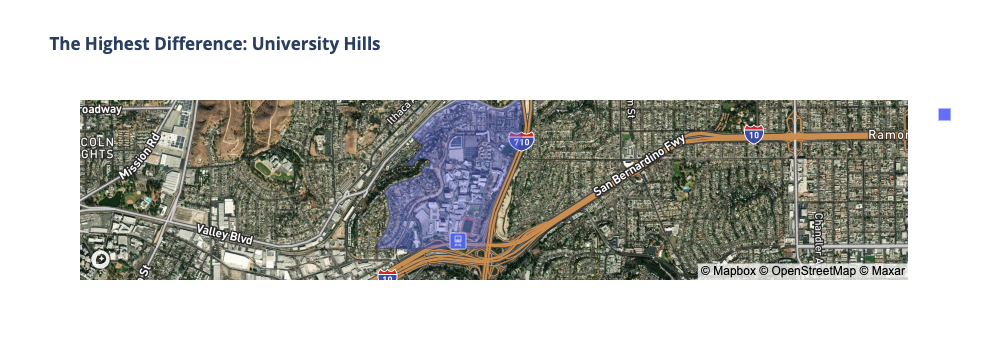

In [134]:
px.choropleth_mapbox(comgdfhigh, 
                     geojson=comgdfhigh.geometry, 
                     locations=comgdfhigh.index, 
                     mapbox_style="satellite-streets",
                     zoom=14, 
                     center = {"lat": center_lat_comgdfhigh, "lon": center_lon_comgdfhigh},
                     hover_data=['community','total_parcels','parcel_count','percent','percent_lag'],
                     opacity=0.4,
                     title='The Highest Difference: University Hills')

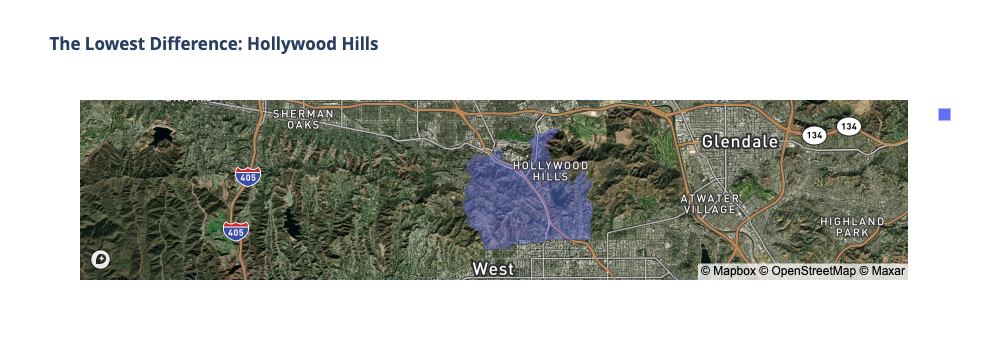

In [135]:
px.choropleth_mapbox(comgdflow, 
                     geojson=comgdflow.geometry, 
                     locations=comgdflow.index, 
                     mapbox_style="satellite-streets",
                     zoom=11, 
                     center = {"lat": center_lat_comgdflow, "lon": center_lon_comgdflow},
                     hover_data=['community','total_parcels','parcel_count','percent','percent_lag'],
                     opacity=0.4,
                     title='The Lowest Difference: Hollywood Hills')

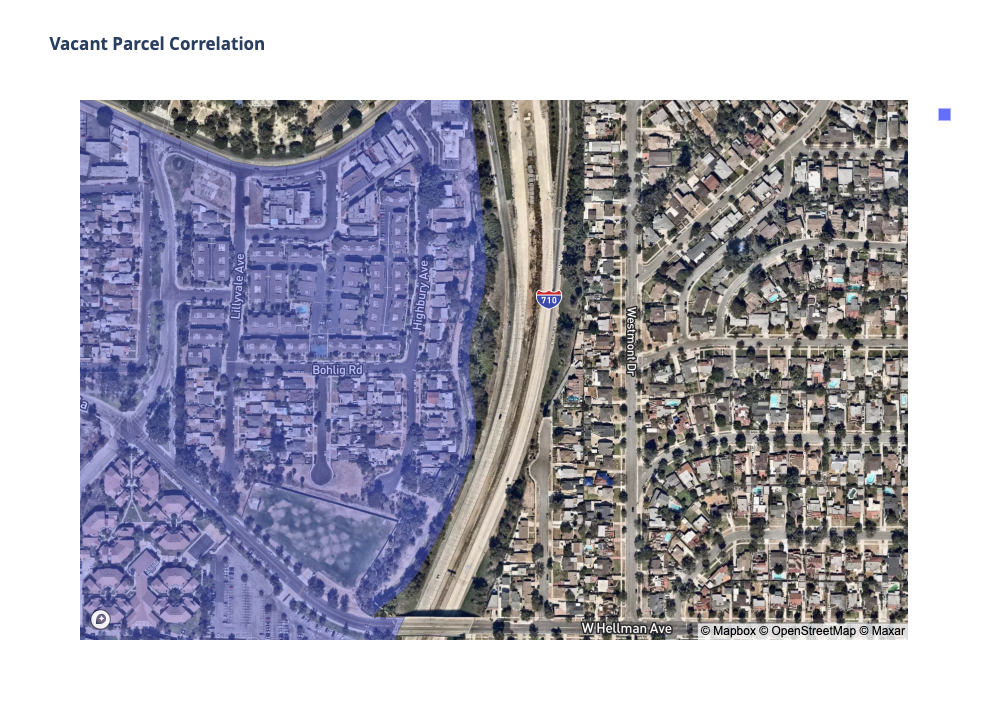

In [130]:
px.choropleth_mapbox(comgdf, 
                     geojson=comgdfhigh.geometry, 
                     locations=comgdf.index, 
                     mapbox_style="satellite-streets",
                     zoom=10, 
                     hover_data=['community','total_parcels','parcel_count','percent','percent_lag'],
                     center = {"lat": 34.1245514405715, "lon": -118.3459018416715},
                     opacity=0.4,
                     title='Vacant Parcel Correlation')

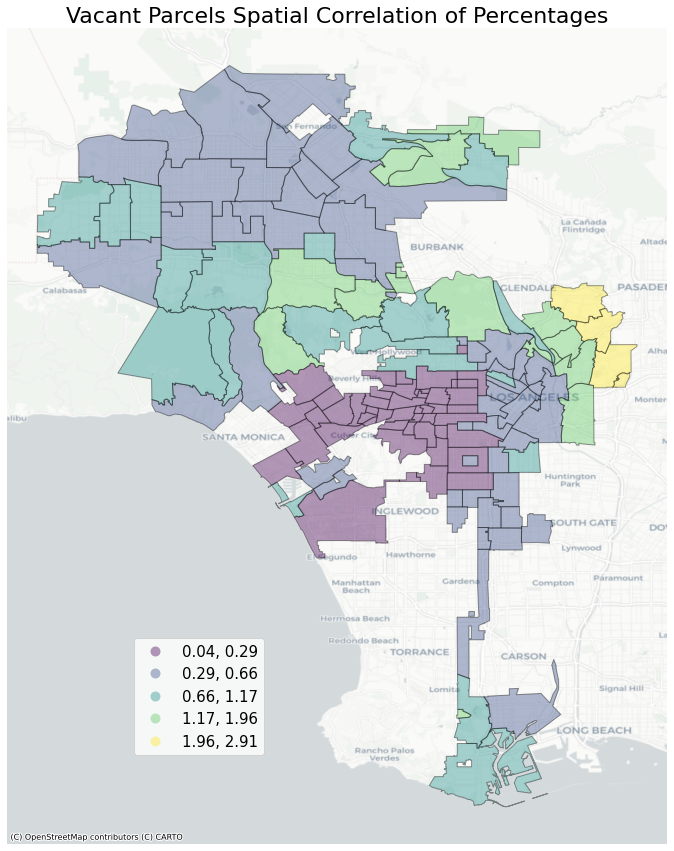

In [127]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
comgdf.plot(ax=ax,
         figsize=(15,15),
         column='percent_lag',
         legend=True,legend_kwds={'loc':'lower right','fontsize': '15','bbox_to_anchor':(.4,.1)},
         alpha=0.4,
        edgecolor='k',
         cmap='viridis',
         scheme='naturalbreaks')

ax.axis('off')
ax.set_title('Vacant Parcels Spatial Correlation of Percentages',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron, crs=comgdf.crs)

plt.savefig('VacparSpatial_Corr_.png', bbox_inches='tight')

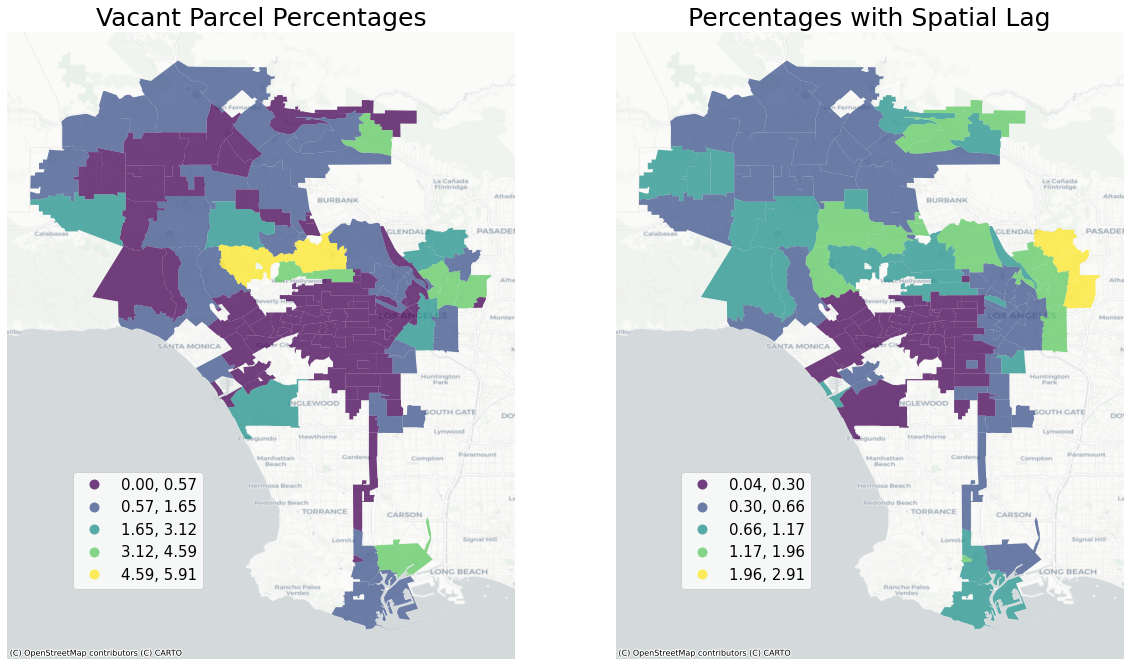

In [144]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
comgdf.plot(ax=ax[0], # this assigns the map to the left subplot
         column='percent', 
         cmap='viridis', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75,
            legend=True, legend_kwds={'loc':'lower right','fontsize': '15','bbox_to_anchor':(.4,.1)},
           )


ax[0].axis("off")
ax[0].set_title("Vacant Parcel Percentages", size= 25)

ctx.add_basemap(ax[0],source=ctx.providers.CartoDB.Positron, crs=comgdf.crs)

# spatial lag map on the right
comgdf.plot(ax=ax[1], # this assigns the map to the right subplot
         column='percent_lag', 
         cmap='viridis', 
         scheme='NaturalBreaks',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75,
            legend=True,legend_kwds={'loc':'lower right','fontsize': '15','bbox_to_anchor':(.4,.1)})

ax[1].axis("off")
ax[1].set_title("Percentages with Spatial Lag", size= 25)
ctx.add_basemap(ax[1],source=ctx.providers.CartoDB.Positron, crs=comgdf.crs)

plt.show()

In [31]:
# interactive version needs to be in WGS84
comgdf_web = comgdf.to_crs('EPSG:4326')

In [32]:
vacgdf_web = vacgdf.to_crs('EPSG:4326')

In [33]:
minx, miny, maxx, maxy = comgdf_web.geometry.total_bounds
center_lat_comgdf_web = (maxy-miny)/2+miny
center_lon_comgdf_web = (maxx-minx)/2+minx

In [34]:
median = comgdf_web.percent_lag.describe()
comgdf_web.percent_lag.describe()

count    139.000000
mean       0.595153
std        0.566286
min        0.039829
25%        0.191330
50%        0.425011
75%        0.781203
max        2.913566
Name: percent_lag, dtype: float64

In [82]:
fig = px.choropleth_mapbox(comgdf_web, 
                     geojson=comgdf_web.geometry, # the geometry column
                     locations=comgdf_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='percent_lag',
                     color_continuous_scale='RdYlGn_r', title='Percentages of Vacant Parcels by Neighborhood',
                           color_continuous_midpoint = 0.425, # put the median as the midpoint
                     range_color =(0,0.425*2),
                     hover_data=['community','total_parcels','parcel_count','percent','percent_lag'],
                     center = {"lat": center_lat_comgdf_web, "lon": center_lon_comgdf_web},
                     opacity=0.5,
                     width=1000,
                     height=800,
                     labels={
                             'percent_lag':'Vacant Parcel Percentages (Spatial Lag)',
                             'percent':'Vacant Parcel Percentages',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})

fig.write_html("SpatialCorr_plotly.html")

In [36]:
y = comgdf.percent
moran = Moran(y, wq)
moran.I

0.1902944385199437

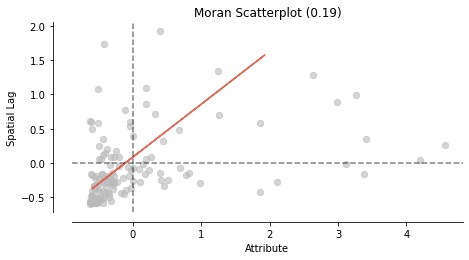

<Figure size 432x288 with 0 Axes>

In [137]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

plt.savefig('moran_1.png')

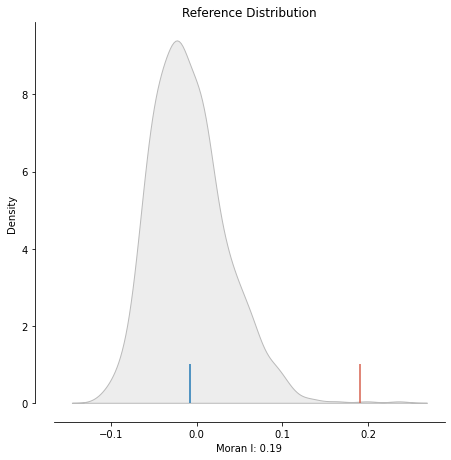

In [136]:
plot_moran_simulation(moran,aspect_equal=False)

plt.savefig('reference distribution.png')

In [39]:
moran.p_sim

0.003

In [40]:
# calculate local moran values
lisa = esda.moran.Moran_Local(y, wq)

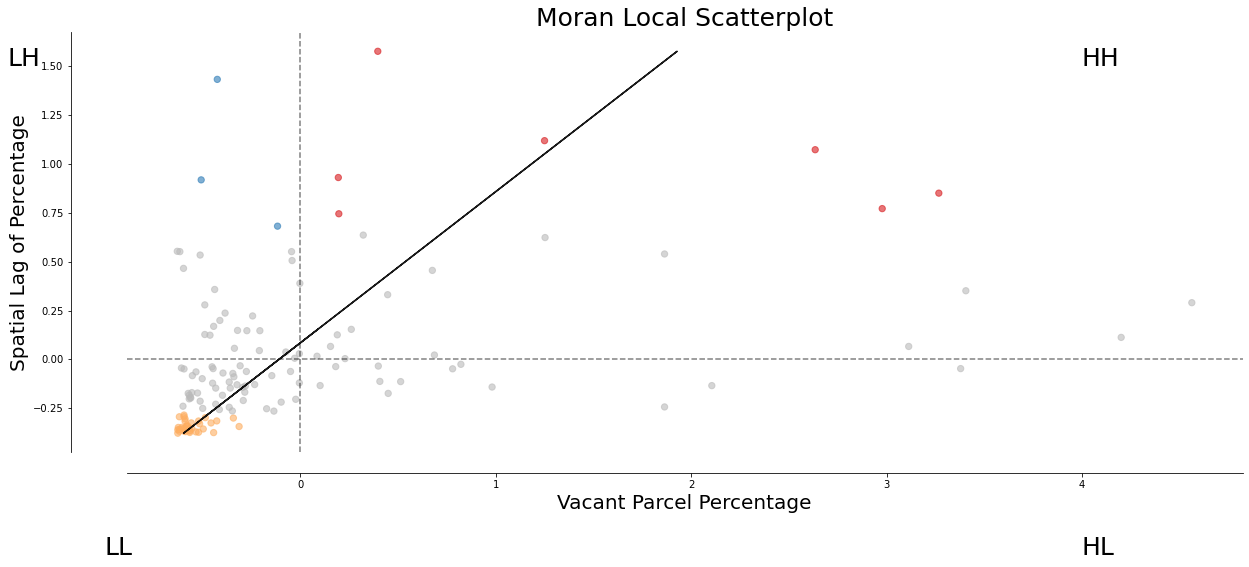

<Figure size 432x288 with 0 Axes>

In [140]:
# Plot
fig,ax = plt.subplots(figsize=(20,15))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Vacant Parcel Percentage", fontsize=20)
ax.set_ylabel('Spatial Lag of Percentage', fontsize=20)
ax.set_title('Moran Local Scatterplot', fontsize=25)

# add some labels
plt.text(4, 1.5, "HH", fontsize=25)
plt.text(4, -1, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

plt.savefig('moran_scatter.png')

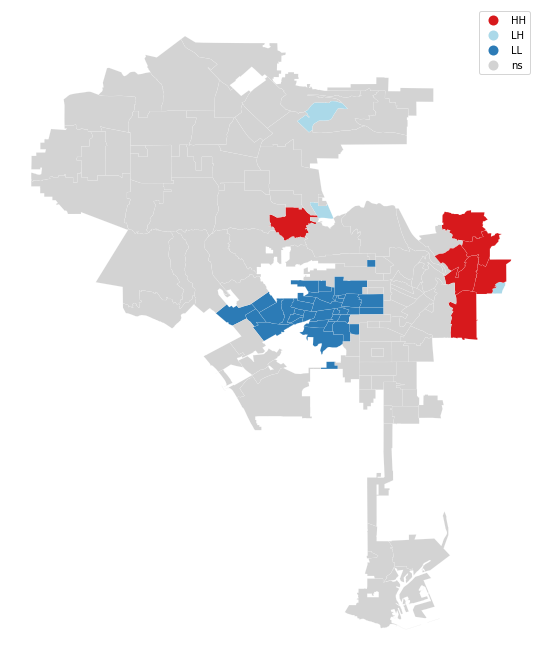

In [42]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, comgdf, p=0.05, ax=ax)
plt.show()

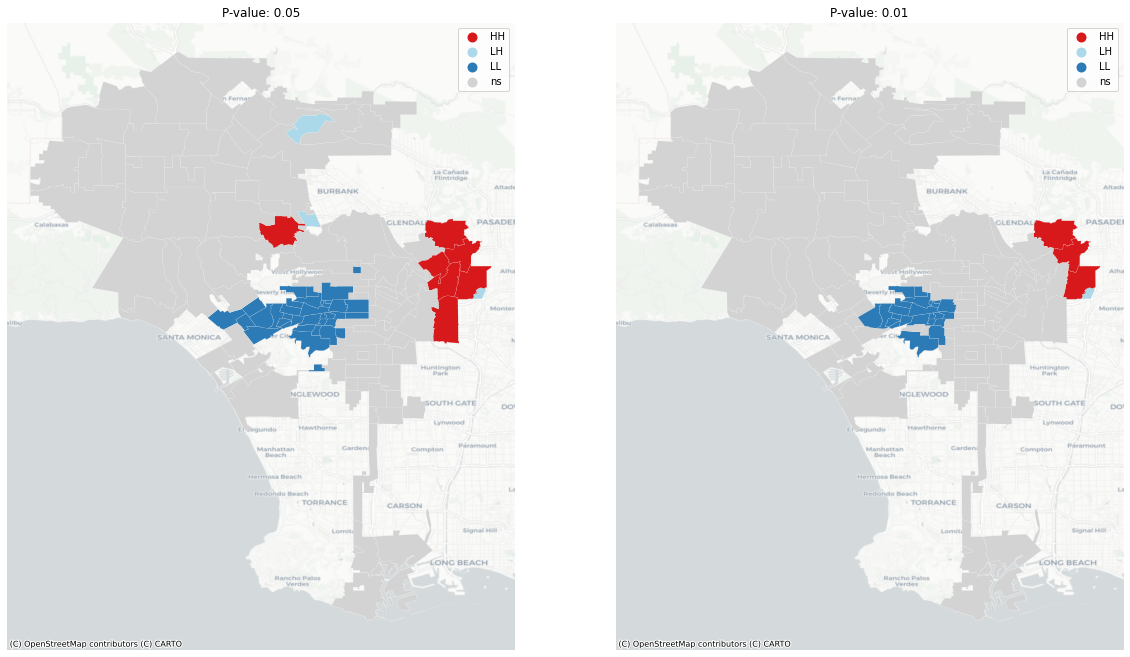

<Figure size 432x288 with 0 Axes>

In [143]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
lisa_cluster(lisa, comgdf, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

ctx.add_basemap(ax[0],source=ctx.providers.CartoDB.Positron, crs=comgdf.crs)

# spatial lag map on the right
lisa_cluster(lisa, comgdf, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

ctx.add_basemap(ax[1],source=ctx.providers.CartoDB.Positron, crs=comgdf.crs)

plt.show()

plt.savefig('pvalue.jpg')

In [44]:
fig = px.choropleth_mapbox(vacgdf_web, 
                     geojson=vacgdf_web.geometry, # the geometry column
                     locations=vac_web.index, # the index
                     mapbox_style="satellite-streets",
                     zoom=9, 
                     color='percent_lag',
                     color_continuous_scale='RdYlGn_r',
                           color_continuous_midpoint = 0.425, # put the median as the midpoint
                     range_color =(0,0.425*2),
                     hover_data=['community','total_parcels','parcel_count','percent','percent_lag'],
                     center = {"lat": center_lat_comgdf_web, "lon": center_lon_comgdf_web},
                     opacity=0.5,
                     width=1000,
                     height=800,
                     labels={
                             'percent_lag':'Vacant Parcel Percentages (Spatial Lag)',
                             'percent':'Vacant Parcel Percentages',
                     })
fig.update_traces(marker_line_width=0.1, marker_line_color='white')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

NameError: name 'vac_web' is not defined